# Melody squares for Arvo Pärt's *Summa*

In [1]:
import music21
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import interval_motifs


In [2]:
# Path to the score of Summa
SUMMA_FN = '../excluded/Summa.musicxml'

# Settings and global variables
plt.rcParams['font.sans-serif'] = ['Arial', 'HelveticaNeue', 'Helvetica']

# Save figures
SAVE = False

## Functions

In [3]:
def is_melisma(note):
    return len(note.lyrics) == 0

In [4]:
def get_step_curve(stream, include_repetitions=True, include_melismas=False):
    notes = [stream.flat.notes[0]]
    for note in stream.flat.notes[1:]:
        if note.pitch.ps != notes[-1].pitch.ps or include_repetitions:
            if not is_melisma(note) or include_melismas:
                notes.append(note)
    pitches = [n.pitch.ps for n in notes]
    onsets = [float(n.offset) for n in notes]
    return np.array([onsets, pitches])

In [5]:
from collections import Counter
from itertools import product

def motif_histogram(motifs, min_value=None, max_value=None, normalize=True, smooth=0):
    if min_value is None: min_value = np.floor(motifs.min())
    if max_value is None: max_value = np.ceil(motifs.max())
    dim = motifs.shape[1]
    counts = Counter([tuple(m) for m in motifs])
    values = np.arange(min_value, max_value+1)
    hist = np.zeros([len(values)] * dim)
    for idx in product(*[np.arange(len(values))]*dim):
        point = tuple([values[i] for i in idx])
        hist[idx] = counts[point]

    # Apply smoothing and normalize
    if normalize:
        hist += smooth
        hist = hist / hist.sum()

    # Make sure that the first interval is the first axis etc
    hist = hist.T 
    return hist, values

In [6]:
def get_histogram(stream, min_value=-12, max_value=12, include_melismas=False):
    _, pitches = get_step_curve(stream, include_melismas=include_melismas)
    motifs = interval_motifs([pitches], 2)
    hist, values = motif_histogram(motifs, min_value=min_value, max_value=max_value)
    hist = pd.DataFrame(hist, index=values, columns=values).sort_index(ascending=False)
    return hist

## Plot summa

In [7]:
score = music21.converter.parse(SUMMA_FN)
soprano, alto, tenor, bass = score.parts

In [8]:
histograms = dict(
    soprano=get_histogram(soprano), 
    alto=get_histogram(alto), 
    tenor=get_histogram(tenor), 
    bass=get_histogram(bass)
)

histograms_melismas = dict(
    soprano=get_histogram(soprano, include_melismas=True), 
    alto=get_histogram(alto, include_melismas=True), 
    tenor=get_histogram(tenor, include_melismas=True), 
    bass=get_histogram(bass, include_melismas=True)
)

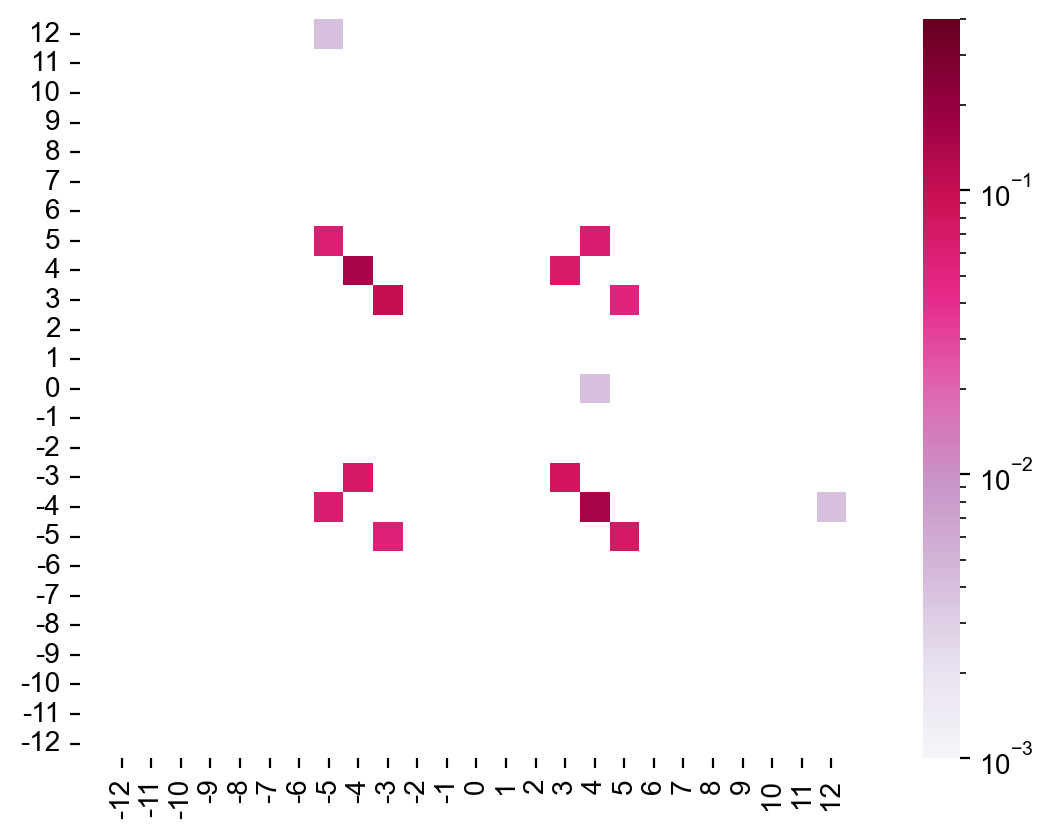

In [9]:
from matplotlib.colors import LogNorm

def show_melodic_motif_histogram(hist, mask_zero=True, **kwargs):
    _kwargs = dict(cmap='PuRd', cbar=False, ax=plt.gca())
    _kwargs.update(kwargs)
    if mask_zero: _kwargs['mask'] = hist == 0
    ax = _kwargs['ax']
    sns.heatmap(hist, **_kwargs)
    ax.axis('equal')
    
show_melodic_motif_histogram(histograms['soprano'], 
    norm=LogNorm(vmin=0.001, vmax=.4), cbar=True)

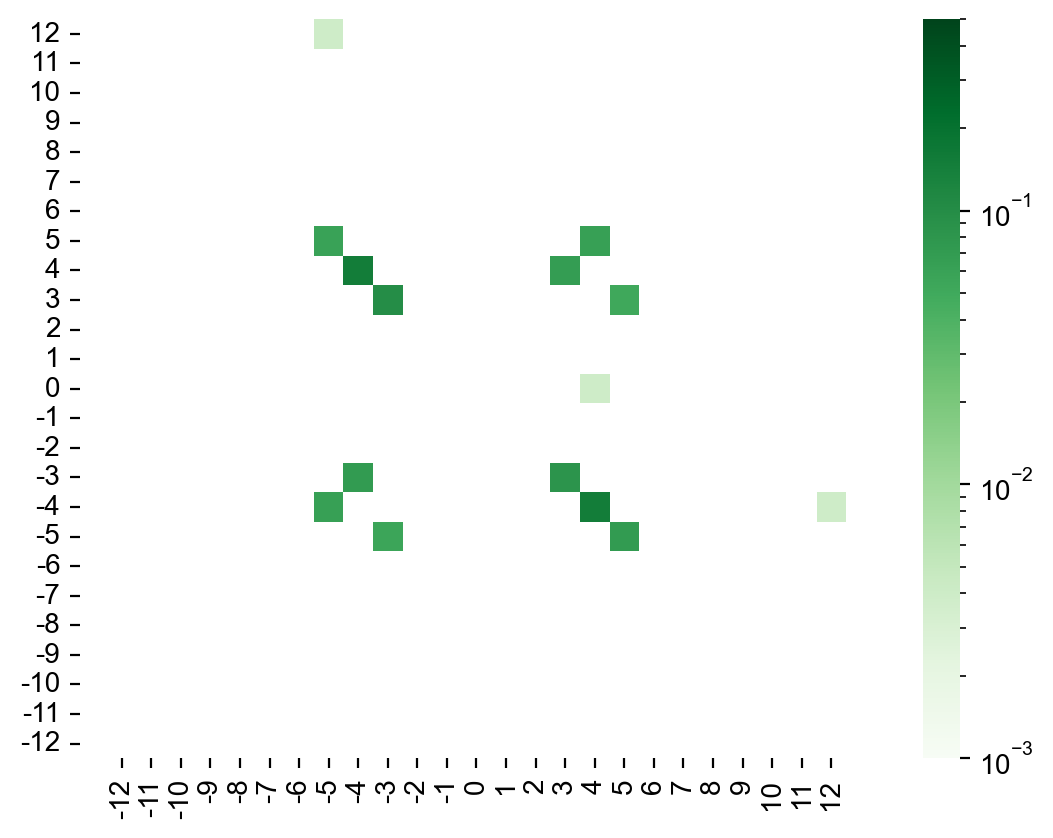

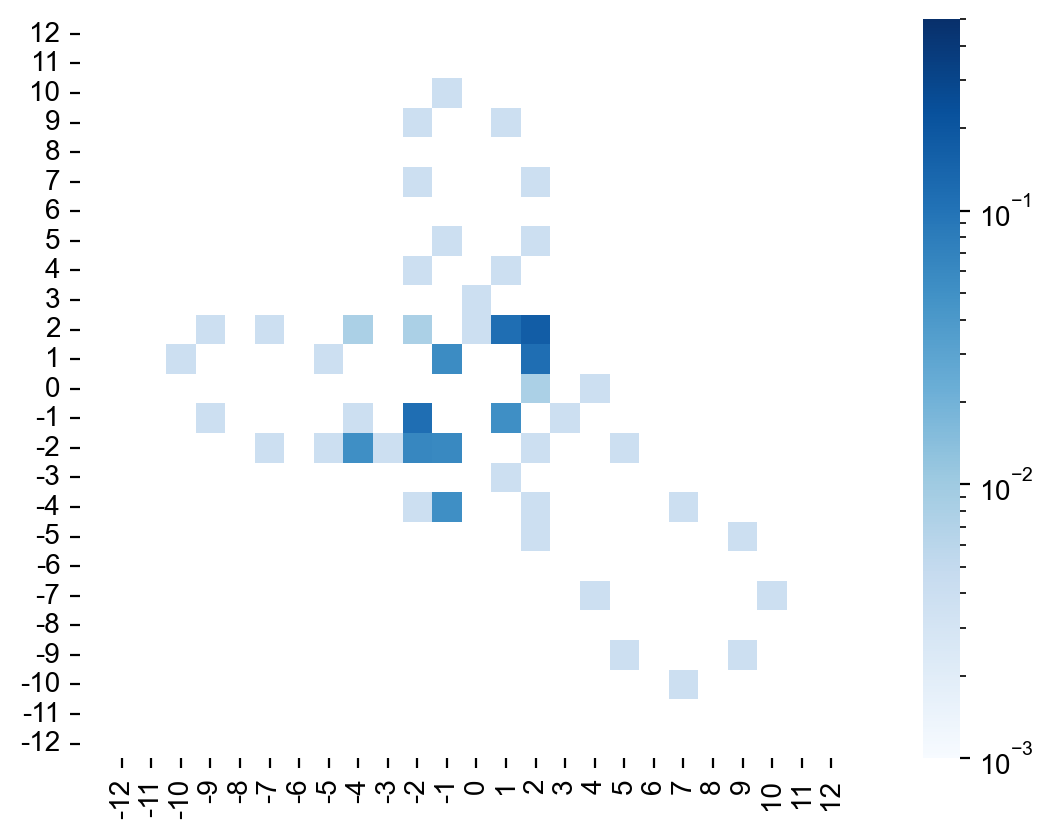

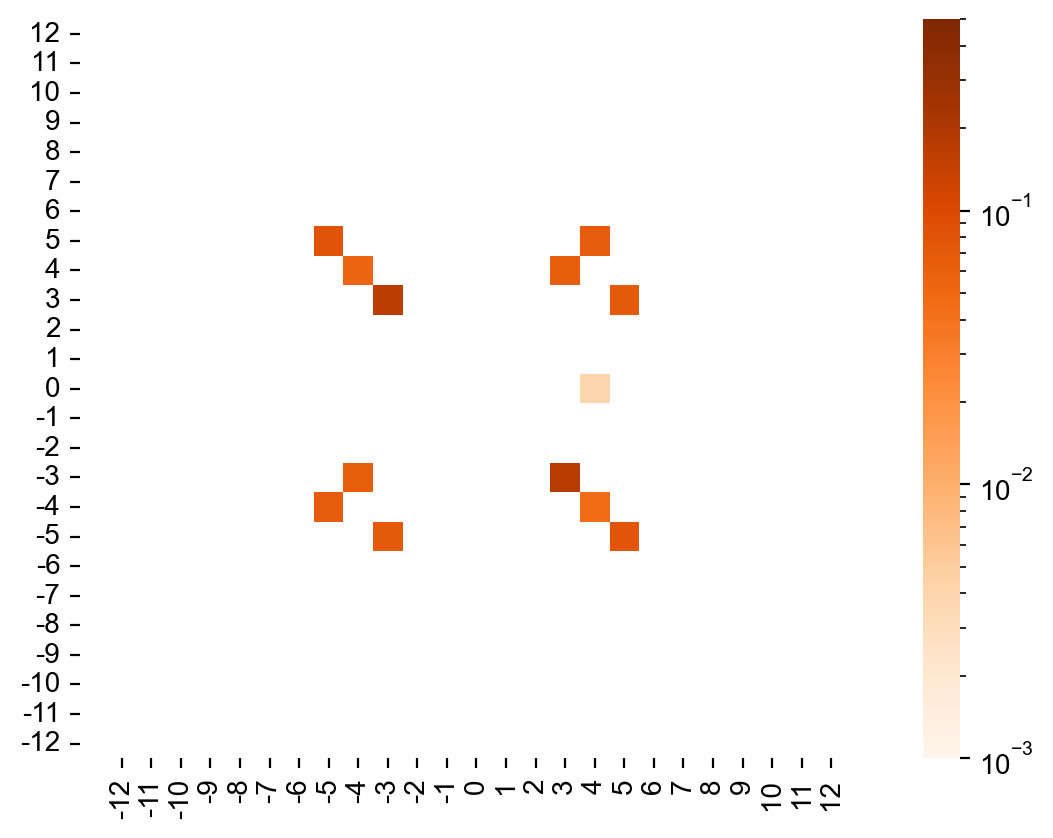

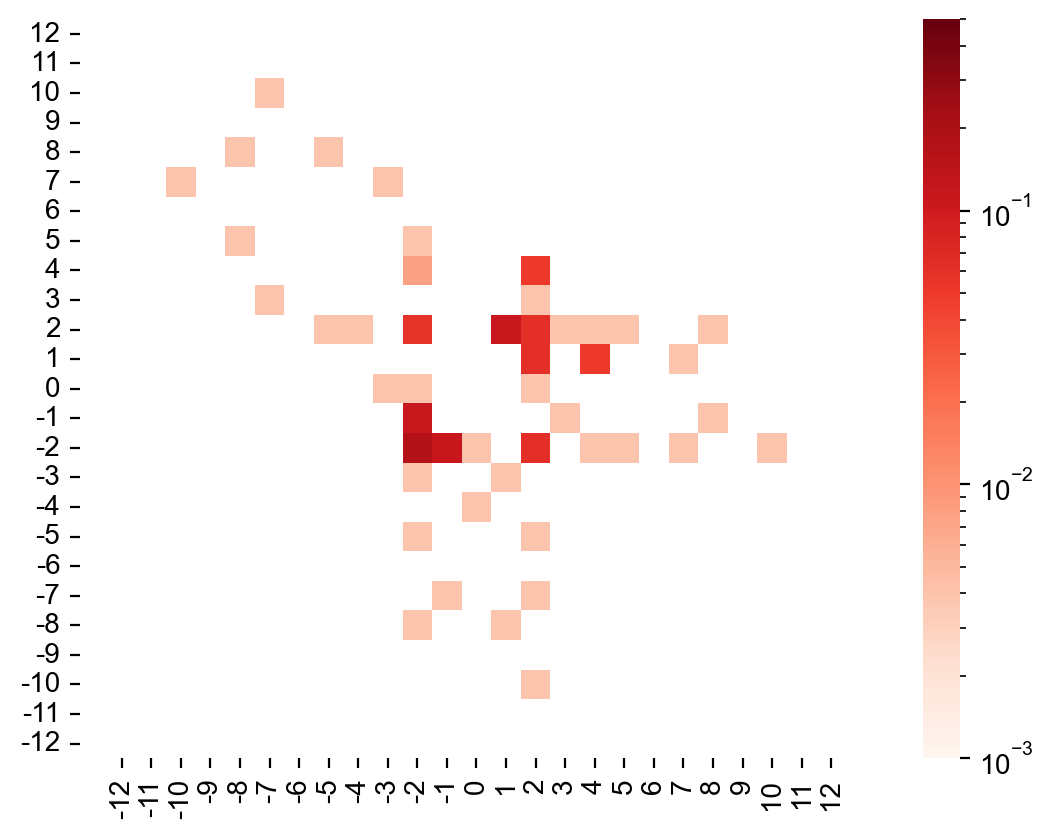

In [10]:
cmaps = dict(soprano='Greens', alto='Blues', tenor='Oranges', bass='Reds')

for voice, hist in histograms.items():
    plt.figure()
    show_melodic_motif_histogram(hist, 
        norm=LogNorm(vmin=0.001, vmax=.5), 
        cmap=cmaps[voice], cbar=True)
    if SAVE:
        plt.savefig(f'../figures/figure-summa/melody-square-{voice}-wo-ornaments.pdf')

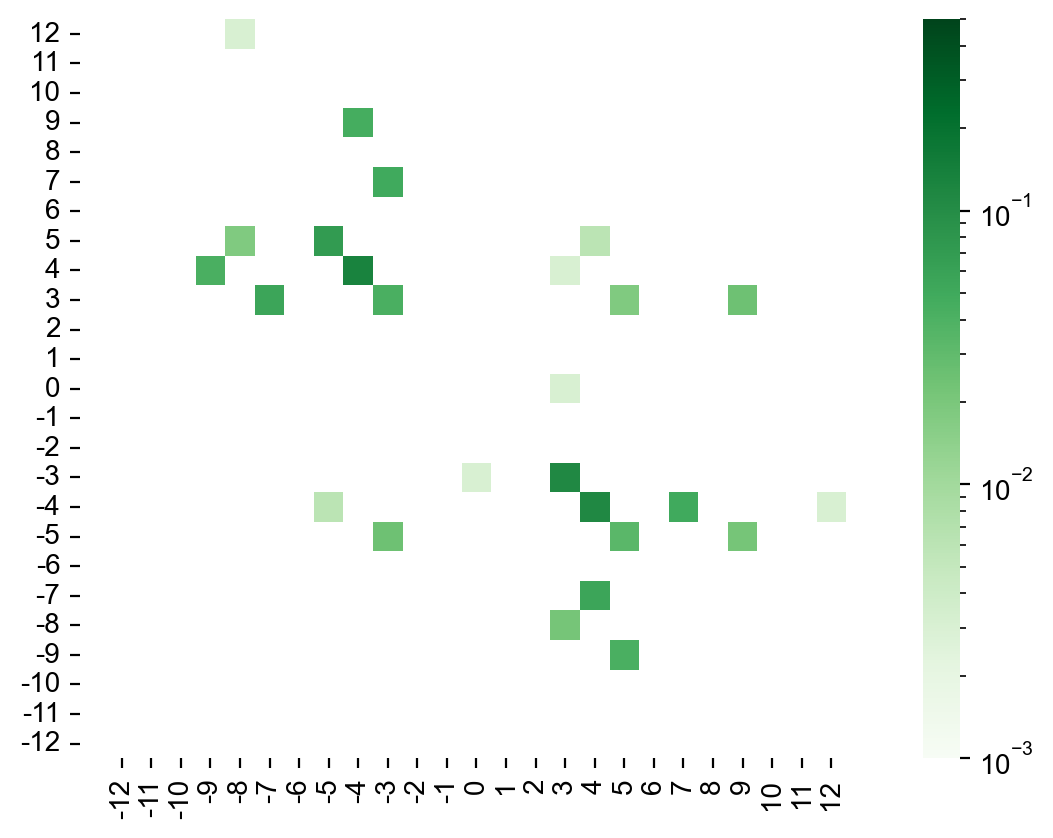

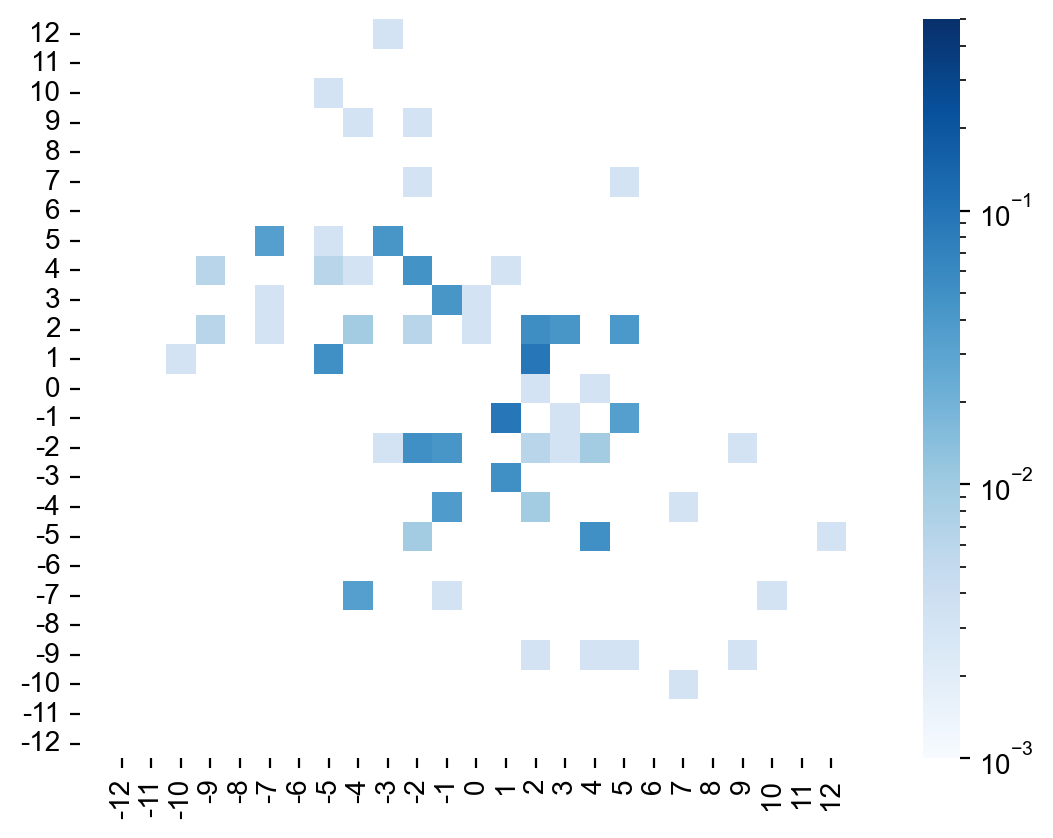

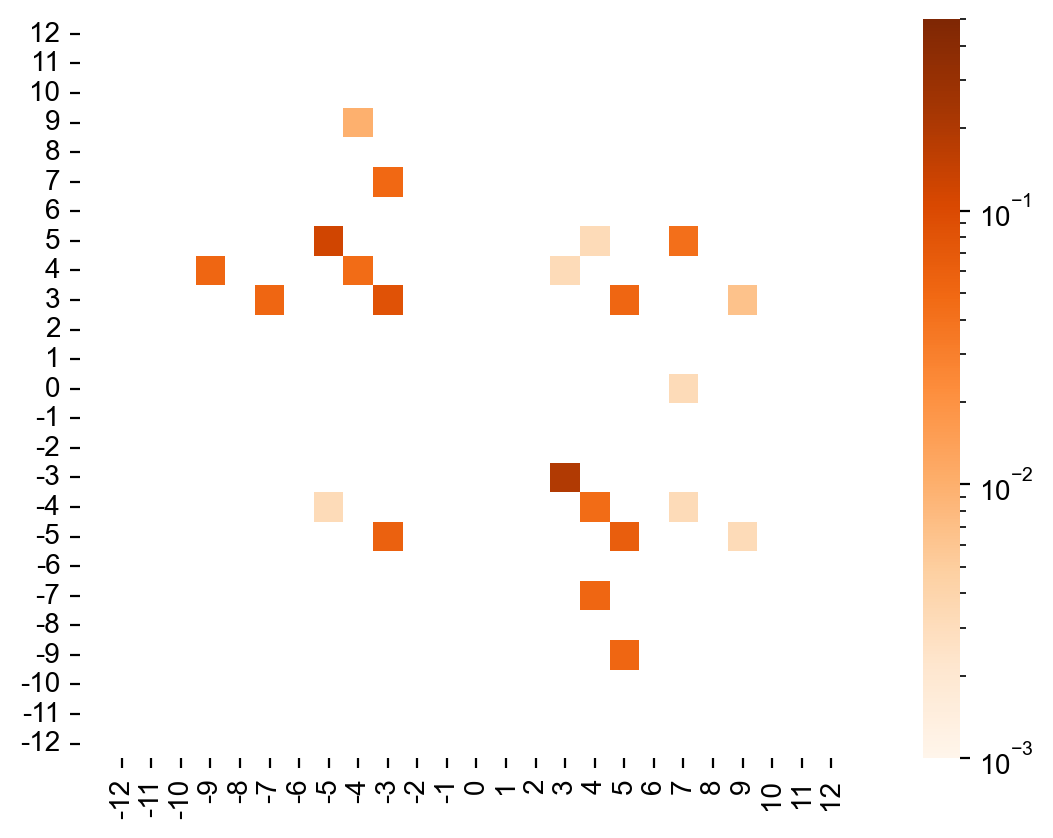

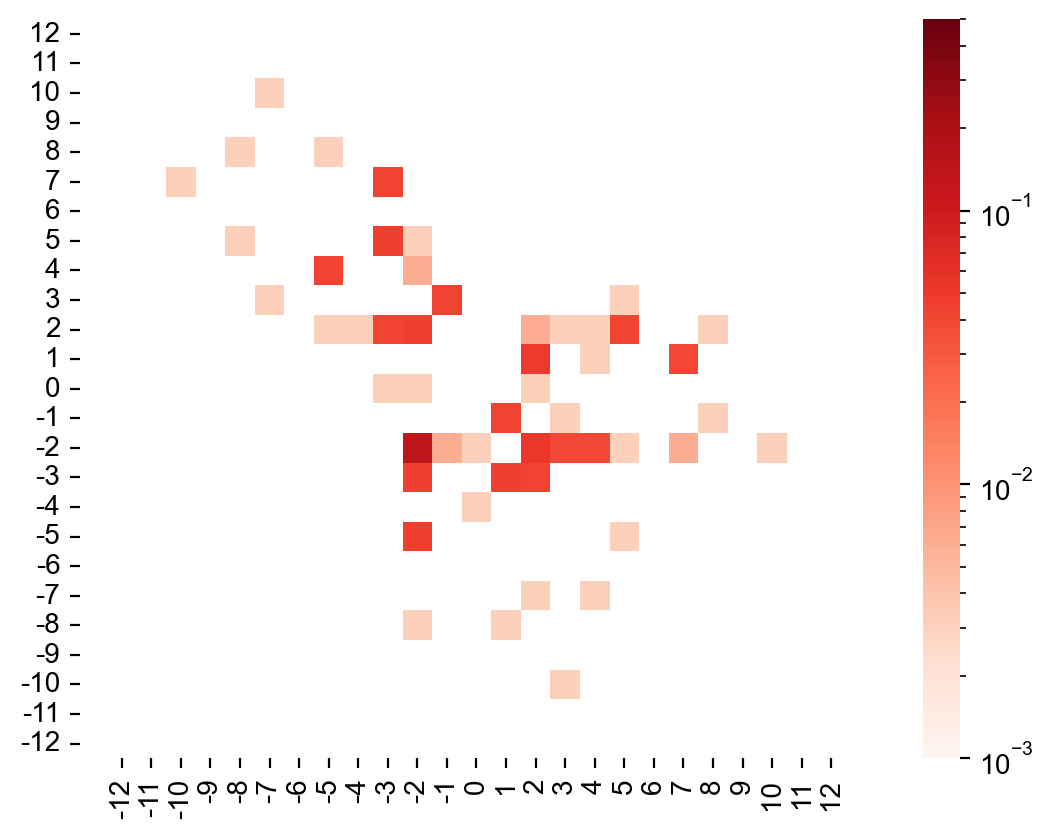

In [11]:
# With melismas/ornaments
for voice, hist in histograms_melismas.items():
    plt.figure()
    show_melodic_motif_histogram(hist, 
        norm=LogNorm(vmin=0.001, vmax=.5), 
        cmap=cmaps[voice], cbar=True)
    if SAVE:
        plt.savefig(f'../figures/figure-summa/melody-square-{voice}-with-ornaments.pdf')